In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd drive/'My Drive'

/content/drive/My Drive


In [0]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import Nadam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.applications.xception import Xception
from keras.models import Model
import keras

Using TensorFlow backend.


In [0]:
directory_root = './Dataset Coklat/'
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width=299
height=299
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Moldy_Cocoa ...
[INFO] Processing Bean_Fraction_Cocoa ...
[INFO] Processing Unfermented_Cocoa ...
[INFO] Processing Whole_Beans_Cocoa ...
[INFO] Processing Fermented_Cocoa ...
[INFO] Processing Broken_Beans_Cocoa ...
[INFO] Image loading completed
CPU times: user 119 µs, sys: 34 µs, total: 153 µs
Wall time: 159 µs


In [0]:
image_size = len(image_list)
print(image_size)

614


In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [0]:
print(label_binarizer.classes_)

['Bean_Fraction_Cocoa' 'Broken_Beans_Cocoa' 'Fermented_Cocoa'
 'Moldy_Cocoa' 'Unfermented_Cocoa' 'Whole_Beans_Cocoa']


In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
base_model = Xception(weights='imagenet', include_top=False)
#add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(200,activation='elu')(x)
x = Dropout(0.4)(x)
x = Dense(170,activation='elu')(x)
predictions = Dense(6,activation='hard_sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Nadam(lr=0.0001), 
loss='binary_crossentropy',metrics=['accuracy'])













83689472/83683744 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )



Epoch 1/50
15/15 [==============================] - 652s 43s/step - loss: 0.4540 - acc: 0.8150 - val_loss: 0.3059 - val_acc: 0.8577
Epoch 2/50
15/15 [==============================] - 644s 43s/step - loss: 0.2622 - acc: 0.8940 - val_loss: 0.2455 - val_acc: 0.8930
Epoch 3/50
15/15 [==============================] - 638s 43s/step - loss: 0.2198 - acc: 0.9181 - val_loss: 0.2450 - val_acc: 0.9214
Epoch 4/50
15/15 [==============================] - 625s 42s/step - loss: 0.1732 - acc: 0.9463 - val_loss: 0.2611 - val_acc: 0.9282
Epoch 5/50
15/15 [==============================] - 622s 41s/step - loss: 0.1548 - acc: 0.9494 - val_loss: 0.2875 - val_acc: 0.9214
Epoch 6/50
15/15 [==============================] - 619s 41s/step - loss: 0.1363 - acc: 0.9630 - val_loss: 0.1916 - val_acc: 0.9458
Epoch 7/50
15/15 [==============================] - 630s 42s/step - loss: 0.1503 - acc: 0.9669 - val_loss: 0.2798 - val_acc: 0.9377
Epoch 8/50
15/15 [==============================] - 663s 44s/step - loss: 

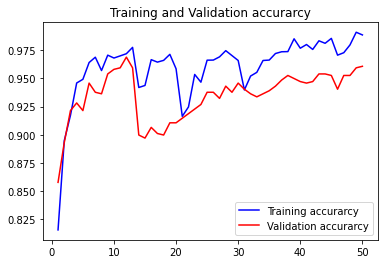

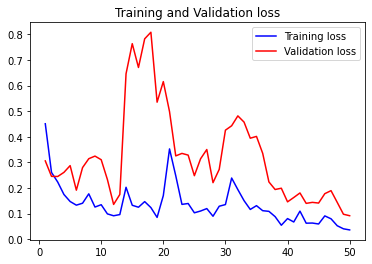

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
123/123 [==============================] - 54s 436ms/step
Test Accuracy: 96.0704629014178
